In [1]:
import numpy as np
from scipy.sparse import diags, linalg
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from time import time

%matplotlib inline

Many computation problems boil down to solving systems of linear equations.  Consider the system,

\begin{array}{lllll}
2x_1 & +3x_2 & -x_3 & = & 6\\
-4x_1 &   & x_3 & = & 7\\
      & x_2 &  -2x_3 & = & 1
\end{array}

We can write the above system in matrix form as:
$$\left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)
\left(
\begin{array}{c}
x_1 \\
x_2 \\
x_3
\end{array}
\right) = \left(
\begin{array}{c}
6 \\
7 \\ 1
\end{array}
\right)
$$

Then we can use Numpy's/Scipy's linear algebra function to find the inverse of the square matrix.  If we Multiply though by the inverse we get,
$$\left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)^{-1}
\left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)
\left(
\begin{array}{c}
x_1 \\
x_2 \\
x_3
\end{array}
\right) = 
\left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)^{-1}
\left(
\begin{array}{c}
6 \\
7 \\ 1
\end{array}
\right)
$$

Which becomes,

$$
\left(
\begin{matrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{matrix}
\right)
\left(
\begin{array}{c}
x \\
y\\
z
\end{array}
\right) = \left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)^{-1}
\left(
\begin{array}{c}
6 \\
7 \\
1 
\end{array}
\right)
$$

which gives our solution,
$$
\left(
\begin{array}{c}
x \\
y\\
z
\end{array}
\right) = \left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)^{-1}
\left(
\begin{array}{c}
6 \\
7 \\
1 
\end{array}
\right)
$$

While Numpy has a command <i>np.linalg.inv</i> to find the matrix inverse, we can solve the whole system with one line of code using <np.linalg.solve</i>.

Let's solve the above system.

In [2]:
#  Define our coefficient matrix and our vector of knowns.
A = np.array( [[2, 3, -1], [-4, 0, 1], [0, 1, -2] ])
Y = np.array( [6, 7, 1])

#  Calculate and multiply though by the matrix inverse to get the solution.
Ainv = np.linalg.inv(A)
X = np.matmul(Ainv, Y)

print(X)
x1 = X[0]
x2 = X[1]
x3 = X[2]

#  Test to see if our solution works.
print(  2 * x1 + 3 * x2 - x3)
print( np.matmul(A, X))

#  We can do the same thing with a single line using the solve function.
print( np.linalg.solve(A, Y) )

[-1.45454545  3.36363636  1.18181818]
5.999999999999999
[6. 7. 1.]
[-1.45454545  3.36363636  1.18181818]


##  Stock Simulator

In a previous video, we used  Monte Carlo techniques to simulate the behavior of a stock.  Our model was,

\begin{equation}
\frac{S_{i+1} - S_i}{S_i} = r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i. 
\end{equation}

Which can be written as:
\begin{equation}
S_{i+1} = S_i \left(r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i\right) + S_i
\end{equation}

We can iterate with a for loop to get the price at each day:

Text(0, 0.5, 'Stock Price')

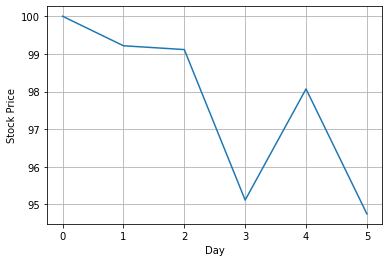

In [3]:
#  Set a constant seed to keep our different pieces of test code the same
np.random.seed(2)

#  Number of days in the simulation and the starting price of the stock.
N_days = 5
S = 100

#  Define the risk-free rate, volatility and time step in days
r = 0.01 / 252.0

#  dt is 1 / sqrt(252) which scales vol down to a daily value. therefore I don't need the sqrt(dt) in the terms involving epsilon
sigma = 0.3 / np.sqrt(252)
dt = 1

#  Sample numbers from the normal distribution for our Monte Carlo simulation
epsilon = np.random.normal( size = N_days )

#  Create a list to store our results and append the initial stock price to it.
S_data = []
S_data.append(S)

#  Do the iteration using the formula above
for i in range(N_days):
    S = S * ( r * dt + sigma * epsilon[i] ) + S
    S_data.append(S)

#  Plot the results
plt.plot(S_data)
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Stock Price')

##  Using Sparse Matrices

While the above works fine, there are computationally more efficient ways to do this.  If one wanted to do, for example, real-time Monte Carlo simulation of dozens of stocks using 10,000 runs per simulation, the above code may not work so well.

But note how we can write our model as a system of linear equations.

Our original equation
\begin{equation}
S_{i+1} = S_i \left(r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i\right) + S_i
\end{equation}
To simplify notation,
$$r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i = \Lambda_i.$$
Which gives,
$$
S_{i+1} = S_i \Lambda_i + S_i
$$
Explicitly writing out the iterations,
\begin{equation}\begin{array}{lcl}S_0                     & = & S_0 \\S_1 - S_0 \Lambda_1 - S_0 & = &  0\\\S_2 - S_1 \Lambda_2 - S_1 & = & 0 \\S_3 - S_2 \Lambda_3 - S_2 & = & 0 \\& \vdots & \\S_i - _{i-} \Lambda_i - S_{i-1} & = & 0 .\\\end{array}\label{unrolled}\end{equation}
In matrix form,
\begin{equation} \left( \begin{matrix} 1 & 0 & 0 & 0 & \cdots & 0 \\ \Lambda_1 + 1 & -1 & 0 & 0 & \cdots & 0 \\ 0 & \Lambda_2 + 1 & -1 & 0 & \cdots & 0 \\ 0 & 0 & \Lambda_3 + 1 & -1 & \cdots & 0 \\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & 0 & \Lambda_5 + 1 & -1 \end{matrix} \right) \left( \begin{array}{c} S_0 \\ S_1 \\ S_2 \\ S_3 \\ \vdots \\ S_i \\ \end{array} \right) = \left( \begin{array}{c} S_0 \\ 0 \\ 0 \\ 0 \\ \vdots \\ 0 \\ \end{array} \right). \label{simple_matrix} \end{equation}

Note also, the the above matrix is "sparse" meaning that almost all eintries are zero.  In many cases, we can take advantage of sparse matrix algorithms which can calculate the inverse quicker than if the matrix were dense.  Furthermore, since most entries are zero, we can save memory by only storing the non-zero entries along with their position in the matrix.

Let's repeat the above calculation using the sparse matrix libraies from <i>scipy.sparse</i>.

Text(0, 0.5, 'Stock Price')

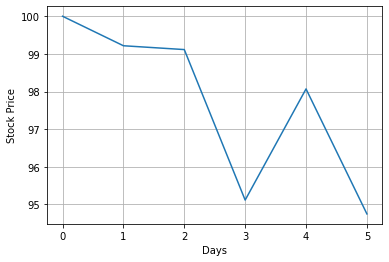

In [4]:
#  Reset the random seed
np.random.seed(2)

#  Define the stock price initially, the number of days, the interest rate and volatility
N_days = 5

S0 = 100.0
r = 0.01 / 252
dt = 1.0
sigma = 0.3 / np.sqrt(252)

epsilon = np.random.normal( size = N_days )

#  For the diags command, we need to define the entries on the diagonals.
Lambda = r * dt + sigma * epsilon
ones = -np.ones( N_days + 1); ones[0] = 1
L = Lambda + 1

#  Build the matrix
M = diags([L, ones], [-1, 0], format = 'csc')
Y = np.zeros( N_days + 1); Y[0] = S0

#  Solve the system
S = linalg.spsolve(M, Y)
plt.plot(S)
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Stock Price')

In [5]:
#  Compare the results of the two methods to make sure they are the same.
print(S_data)
print(S)
np.allclose(S_data, S)

[100, 99.21636995313291, 99.11480606975978, 95.11744359403632, 98.06968807185457, 94.74972862038193]
[100.          99.21636995  99.11480607  95.11744359  98.06968807
  94.74972862]


True

##  Multiple Simulations
###  Loop

Looping, though inefficient, is conceptually a lot easier.  We can repeat the above loop calculation $N_{sim}$ times, appending the results of each run ito an array.

As a reminder, our iteration equation is:
\begin{equation}
S_{i+1} = S_i \left(r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i\right) + S_i
\end{equation}

Recall that $\epsilon$ is a normally distributed random number.  It is not important exactly which numbers are chosen only that they are randomly distributed. But since we want the results of this simulation to be exactly the same as a simulation involving matrices, we need to make sure that the random numbers used at each iteration is the same for both algorithms. 

In the case of $N_{days} = 5$, We need to calculate 5 random numbers. But we are calculating six and intentionally deleting the first element of the array. 


Ellapsed time =  0.0010013580322265625


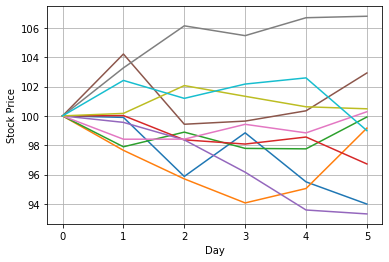

In [6]:
np.random.seed(2)

N_sims = 10

S0 = 100.0
r = 0.01 / 252
dt = 1.0
sigma = 0.3 / np.sqrt(252)

N_days = 5

data = []
start = time()
for i in range(N_sims):
    S0 = 100
    S = []
    
    epsilon = np.random.normal( size = N_days+1 )
    epsilon = np.delete(epsilon, 0)
    
    Lambda = r * dt + sigma * epsilon
    S.append(S0)
    
    for j in range(N_days):
        S0 = S0 * Lambda[j] + S0
        S.append(S0)
    
    S = np.array(S)
    data.append(S)
end = time()
print('Ellapsed time = ', end - start)

#  Don't bother plotting if there are more than ten simulations
if len(data) <= 10:
    for i in range(len(data)):
        plt.plot(data[i])
        plt.grid(True)
        plt.xlabel('Day')
        plt.ylabel('Stock Price')

##  Multiple Sims with Matrices

Recall that with the loop, for $N_{days} = 5$, We calculated six random numbers but kept only the last five. 

With the matrix, we are essentially stitching together $N_{sim}$  number of $(N_{days} + 1) \times (N_{days} + 1)$ matrices.  The +1 is because we are adding on the “zeroth” day.  So the total number of elements along the diagonal is,  $N_{sims} ( N_{days} + 1)$ or as we wrote in the code, $N+{sims}N_{days} + N_{sims}$.

The diagonal below the main  involving Lambda will have one fewer element.     We create a vector of random numbers the same size as the diagonal and then delete the first element.  Then we need to reset every $N_{days} + 1$ element that correspond with a new simulation run.   Because we will enter the values $\Labda + 1$ into the matrix, we set every $N_{days} + 1$ to -1 so that it will cancel out and be zero when we insert it.

The elements that were reset to zero corresponds to the elements we have deleted in the loop code above. 

For two simulation runs, the matrix is shown below.  The subscripts denote (simulation number, day number).

\begin{equation}
\left(
\begin{matrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
\Lambda_{1,1} + 1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & \Lambda_{1,2} + 1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & 0 & \Lambda_{1,3} + 1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & \Lambda_{1,4} - 1 & -1 &0 & 0 & 0 & 0 & 0 & 0 & 0   \\
0 & 0 & 0 & 0 & \Lambda_{1,5} + 1 & -1 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \Lambda_{2,1} + 1 & -1 & 0 & 0 & 0 & 0  \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \Lambda_{2,2} + 1 & -1 & 0 & 0 & 0  \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \Lambda_{2,3} + 1 & -1 & 0 & 0  \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \Lambda_{2,4} + 1 & -1 & 0  \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \Lambda_{2,5} + 1 & -1  \\
\end{matrix}
\right)
\left(
\begin{array}{l}
S_0 \\
S_{1,1} \\
S_{1,2} \\
S_{1,3} \\
S_{1,4} \\
S_{1,5} \\
S_0 \\
S_{2,1} \\
S_{2,2} \\
S_{2,3} \\
S_{2,4} \\
S_{2,5}
\end{array}
\right)
\end{equation}

$$
=\left(
\begin{array}{l}
S_0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
S_0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{array}
\right)
$$

Ellapsed time =  0.0019910335540771484
(10, 6)


Text(0, 0.5, 'Stock Price')

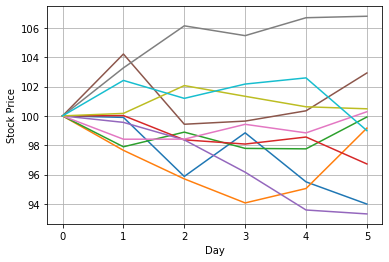

In [7]:
#  Reset the random seed
np.random.seed(2)

#  Numer of simulations
N_sims = 10

#  Stock information
S0 = 100.0
r = 0.01 / 252
dt = 1.0
sigma = 0.3 / np.sqrt(252)

#  Number of days per simulation
N_days = 5

start = time()

#  Create an arraoy of random numbers, then delete the first element
epsilon = np.random.normal(  size = (N_sims * N_days + N_sims) )
epsilon = np.delete(epsilon, 0)

#  Create our Lambda 
Lambda = r * dt + sigma *  epsilon
Lambda[N_days:N_days * N_sims + N_sims:N_days+1] = -1

ones = -np.ones((N_sims * N_days + N_sims))
ones[0:-1:N_days+1] = 1

M = diags( [Lambda + 1, ones], [-1, 0], format = 'csc')

Y = np.zeros( (N_sims * N_days + N_sims) )
Y[0:-1:N_days + 1] = S0

X = linalg.spsolve(M, Y)

end = time()
X = np.reshape(X, (N_sims, N_days+1))

print('Ellapsed time = ', end - start)

rows, cols = X.shape
if rows <= 11:
    for i in range(N_sims):
        plt.plot(X[i,:])

print(X.shape)
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Stock Price')